In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
import sklearn.preprocessing as prep
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
flc = '/Users/pinqingkan/Desktop/Codes/Course_ISLR/data/'
fname = flc + 'Caravan.csv'

In [3]:
X = pd.read_csv(fname, index_col = 0)

In [4]:
y = X.iloc[:, -1].map({'Yes': 1, 'No': 0}) # labels
x = X.iloc[:, :-1] # predictors
Nrows, Ncols = x.shape

### section 1
implementing 4.6.6 in Python

In [5]:
# standardizing the whole dataset (4.6.6)
norm = prep.StandardScaler()
norm.fit(x)
x0 = norm.transform(x)

/Users/pinqingkan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pinqingkan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [6]:
# using the training-testing split in 4.6.6
Ndata = 1000
xtest0  = x0[:Ndata, :]
xtrain0 = x0[Ndata:, :]
ytest  = y[:Ndata]
ytrain = y[Ndata:]

In [7]:
model = KNN(n_neighbors = 1).fit(xtrain0, ytrain)

In [8]:
model.score(xtest0, ytest)

0.882

In [9]:
# since the % of label = 1 is so low, the accuracy is not good considering the full population
len(np.where(ytest == 1)[0]) / Ndata

0.059

In [10]:
ytest2 = model.predict(xtest0)
metricC = confusion_matrix(ytest, ytest2)

In [11]:
# however, if we target only those labeled as 1 by model, the % is better than without target
metricC[1, 1] / sum(metricC[:, 1])

0.11688311688311688

In [12]:
# looking at different values of neighbors
N = 7
scores0 = np.zeros(N)
pctTP = np.zeros(N)
for iN in range(1, N+1):
    model = KNN(n_neighbors = iN).fit(xtrain0, ytrain)
    scores0[iN-1] = model.score(xtest0, ytest)
    ytest2 = model.predict(xtest0)
    metricC = confusion_matrix(ytest, ytest2)
    pctTP[iN-1] = metricC[1, 1] / sum(metricC[:, 1])

Text(0.5, 1.0, 'precision')

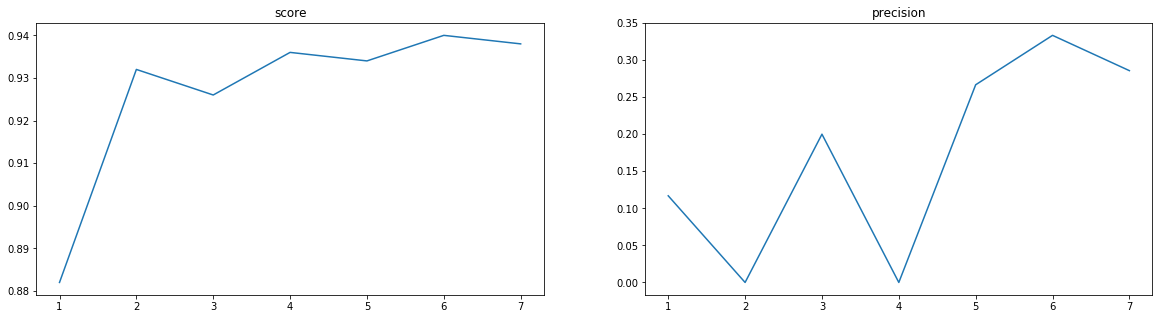

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
ax1.plot(np.arange(1, N+1), scores0)
ax1.set_title('score')
ax2.plot(np.arange(1, N+1), pctTP)
ax2.set_title('precision')

In [14]:
model = LogisticRegression().fit(xtrain0, ytrain)#class_weight = {1: 2}

/Users/pinqingkan/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
ptest2 = model.predict_proba(xtest0)[:, 1]

with logistic regression, setting lower probability (~0.2, 0.3) than 0.5 achieves similar level of precision

In [16]:
pctTP = []
for iprob in np.arange(0.1, 0.6, 0.05):
    inds = np.where(ptest2 > iprob)[0]
    pctTP.append(sum(ytest.iloc[inds]) / len(inds))

Text(0.5, 0, 'threshold of pred. prob.')

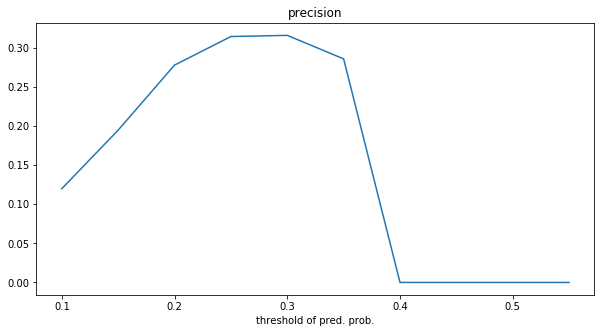

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
ax1.plot(np.arange(0.1, 0.6, 0.05), pctTP)
ax1.set_title('precision')
ax1.set_xlabel('threshold of pred. prob.')

### section 2
further exploration

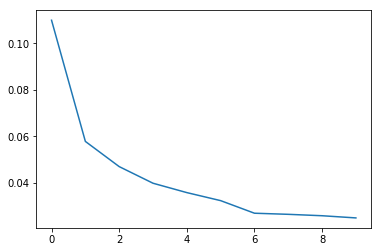

In [18]:
pca = PCA(n_components = Ncols, svd_solver = 'full')
pca.fit(x0)
lamda = pca.explained_variance_ratio_
plt.plot(lamda[:10])

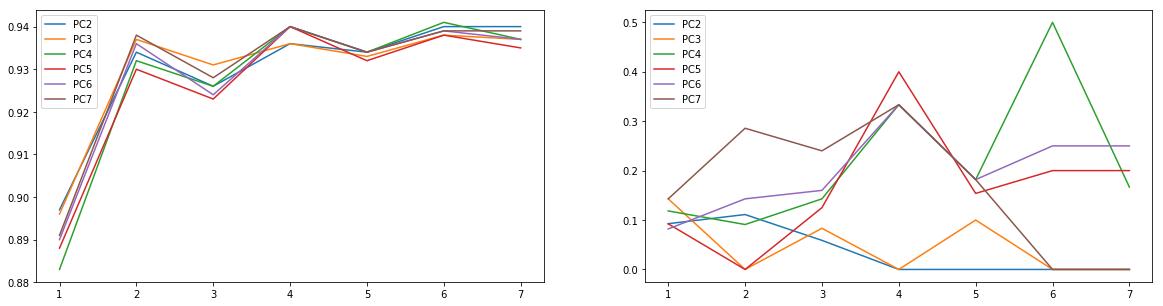

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))
for iNpc in range(2, 8):
    pca = PCA(n_components = iNpc, svd_solver = 'full', copy = True, whiten = False)
    pca.fit(xtrain0)
    xtrain2 = pca.transform(xtrain0)
    xtest2 = pca.transform(xtest0)
    N = 7
    scores0 = np.zeros(N)
    pctTP = np.zeros(N)
    for iN in range(1, N+1):
        model = KNN(n_neighbors = iN).fit(xtrain2, ytrain)
        scores0[iN-1] = model.score(xtest2, ytest)
        ytest2 = model.predict(xtest2)
        metricC = confusion_matrix(ytest, ytest2)
        pctTP[iN-1] = metricC[1, 1] / sum(metricC[:, 1])
    ax1.plot(np.arange(1, N+1), scores0, label = 'PC' + str(iNpc))
    ax2.plot(np.arange(1, N+1), pctTP, label = 'PC' + str(iNpc))
ax1.legend()
ax2.legend()

In [20]:
Npc = 5
pca = PCA(n_components = Npc, svd_solver = 'full', copy = True, whiten = False)
pca.fit(xtrain0)
xPCA = pca.transform(xtrain0)
xcors = np.zeros((Npc, Ncols))
for iNpc in range(Npc):
    for icol in range(Ncols):
        xcors[iNpc, icol] = np.corrcoef(xPCA[:, iNpc], xtrain0[:, icol])[0, 1]

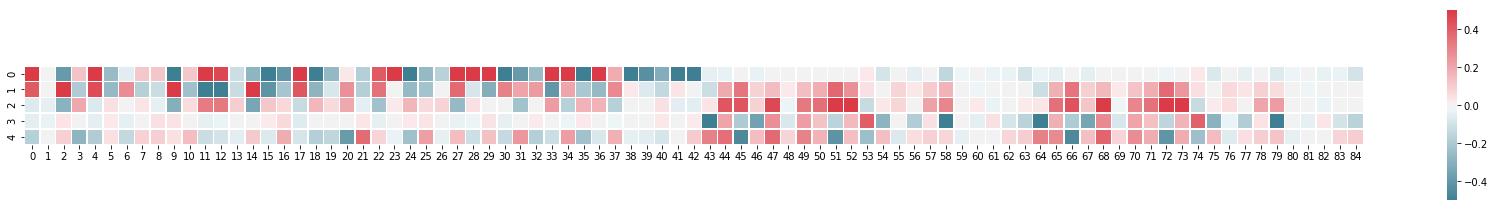

In [21]:
fig = plt.figure(figsize = (30, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(xcors, cmap=cmap, vmax=.5, vmin = -.5, linewidths=.5, square=True, cbar_kws={"shrink": .5})